# Loss Function

In [3]:
yolo_anchors = np.array([(10, 10), (22, 23), (47, 33), (39, 81), (82, 54), (127, 86),
                         (118, 168), (194, 130), (257, 221)], np.float32)

## Decode the output / Encode the input

In the image below, we're gonna predict the $t_i$ values, but surely we need to decode the the actual values. 

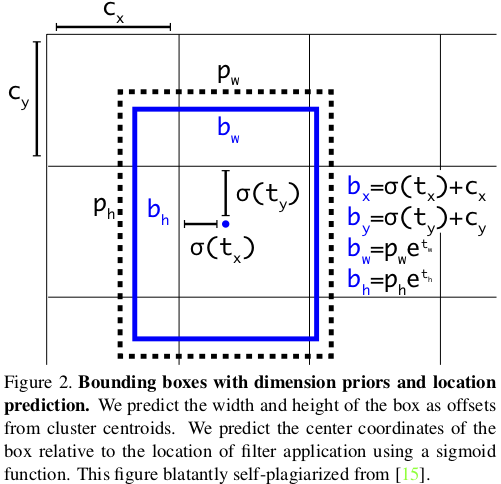

In the original paper it uses different independent logistic classifiers because it may be trained in complex databases with overlapping labels. Since it's not out case we're gonna use a softmax with a cross-entropy loss (instead of binary-crossentropy)

### Disclaimer
The decoding functions are more or less adapted from different github repos. That doesn't means i copied them all, but surely i took inspiration from them because it's the most boring part since it's only a software implementation of trivial functions (once the mechanism it's understood).

Still, it's no easy task. YOLO paper it's commonly known to be difficult to fully understand, and i saw a lot of errors even in StackExchange discussions!


In [6]:
def decode_into_abs(y_pred, valid_anchor, num_classes = 10):
    """
    Given a cell offset prediction from the model, calculate the absolute box coordinates to the whole image.
    note that, we divide w and h by grid size 
    INPUTS:
    y_pred: Prediction tensor from the model output, in the shape of (batch, grid, grid, anchor, 5 + num_classes)
    OUTPUTS:
    y_box: boxes in shape of (batch, grid, grid, anchor, 4), the last dimension is (xmin, ymin, xmax, ymax)
                                                                                #Seems like it's (x,y,w,h)
    objectness: probability that an object exists
    classes: probability of classes
    """
    t_xy, t_wh, objectness, classes = tf.split(
        y_pred, (2, 2, 1, num_classes), axis=-1)
    
    # That's because it's a Logistic classifier
    objectness = tf.sigmoid(objectness)
#     classes = tf.sigmoid(classes)
# we're not gonna sigmoid 'em because we're gonna use tf.nn.softmax_cross_entropy_with_logits
    
    grid_size = tf.shape(y_pred)[1]
    
##########################
    
    # Now i'm gonna get a tensor like this
    #
    # [[[[0, 0]], [[1, 0]], [[2, 0]]],
    #  [[[0, 1]], [[1, 1]], [[2, 1]]],
    #  [[[0, 2]], [[1, 2]], [[2, 2]]]]
    #
    # we have a grid, which can always give us (y, x)
    # if we access grid[x][y]. For example, grid[0][1] == [[1, 0]]
    
    C_xy = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    C_xy = tf.stack(C_xy, axis=-1)
    C_xy = tf.expand_dims(C_xy, axis=2)
    
##########################
    
    # bx = sigmoid(tx) + Cx
    # by = sigmoid(ty) + Cy
    #
    # for example, if all elements in b_xy are (0.1, 0.2), the result will be
    #
    # [[[[0.1, 0.2]], [[1.1, 0.2]], [[2.1, 0.2]]],
    #  [[[0.1, 1.2]], [[1.1, 1.2]], [[2.1, 1.2]]],
    #  [[[0.1, 2.2]], [[1.1, 2.2]], [[2.1, 2.2]]]]
    
    b_xy = tf.sigmoid(t_xy) + tf.cast(C_xy, tf.float32)

    # finally, divide this absolute box_xy by grid_size, and then we will get the normalized bbox centroids
    # for each anchor in each grid cell. b_xy is now in shape (batch_size, grid_size, grid_size, num_anchor, 2)
    #
    # [[[[0.1/3, 0.2/3]], [[1.1/3, 0.2/3]], [[2.1/3, 0.2/3]]],
    #  [[[0.1/3, 1.2/3]], [[1.1/3, 1.2]/3], [[2.1/3, 1.2/3]]],
    #  [[[0.1/3, 2.2/3]], [[1.1/3, 2.2/3]], [[2.1/3, 2.2/3]]]]
    #
    b_xy = b_xy / tf.cast(grid_size, tf.float32)
    
##########################

    # it does not make sense for the box to have a negative width or height. That’s why
    # we take the exponent of the predicted number.
    b_wh = tf.exp(t_wh) * valid_anchor
    
##########################

    y_box = tf.concat([b_xy, b_wh], axis=-1)
    return y_box, objectness, classes
    

In [7]:
def encode_into_rel(y_true, valid_anchor):
    """
    This is the inverse of `decode_into_abs` above. It's turning (bx, by, bw, bh) into
    (tx, ty, tw, th) that is relative to cell location.
    """
    grid_size = tf.shape(y_true)[1]
    C_xy = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    C_xy = tf.expand_dims(tf.stack(C_xy, axis=-1), axis=2)

    b_xy = y_true[..., 0:2]
    b_wh = y_true[..., 2:4]
    t_xy = b_xy * tf.cast(grid_size, tf.float32) - tf.cast(C_xy, tf.float32)

    t_wh = tf.math.log(b_wh / valid_anchor)
    # b_wh could have some cells are 0, divided by anchor could result in inf or nan
    t_wh = tf.where(
        tf.logical_or(tf.math.is_inf(t_wh), tf.math.is_nan(t_wh)),
        tf.zeros_like(t_wh), t_wh)

    y_box = tf.concat([t_xy, t_wh], axis=-1)
    return y_box

## Loss Function
Before starting with the loss function itself we need some utilities:

In [8]:
def xywh_to_x1x2y1y2(box):
    xy = box[..., 0:2]
    wh = box[..., 2:4]

    x1y1 = xy - wh / 2
    x2y2 = xy + wh / 2

    y_box = tf.concat([x1y1, x2y2], axis=-1)
    return y_box


def xywh_to_y1x1y2x2(box):
    x = box[..., 0:1]
    y = box[..., 1:2]
    w = box[..., 2:3]
    h = box[..., 3:4]

    yx = tf.concat([y, x], axis=-1)
    hw = tf.concat([h, w], axis=-1)

    y1x1 = yx - hw / 2
    y2x2 = yx + hw / 2

    y_box = tf.concat([y1x1, y2x2], axis=-1)
    return y_box

In [9]:
def broadcast_iou(box_a, box_b):
    """
    calculate iou between box_a and multiple box_b in a broadcast way.

    inputs:
    box_a: a tensor full of boxes, eg. (B, N, 4), box is in x1y1x2y2
    box_b: another tensor full of boxes, eg. (B, M, 4)
    """

    # (B, N, 1, 4)
    box_a = tf.expand_dims(box_a, -2)
    # (B, 1, M, 4)
    box_b = tf.expand_dims(box_b, -3)
    # (B, N, M, 4)
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_a), tf.shape(box_b))

    # (B, N, M, 4)
    # (B, N, M, 4)
    box_a = tf.broadcast_to(box_a, new_shape)
    box_b = tf.broadcast_to(box_b, new_shape)

    # (B, N, M, 1)
    al, at, ar, ab = tf.split(box_a, 4, -1)
    bl, bt, br, bb = tf.split(box_b, 4, -1)

    # (B, N, M, 1)
    left = tf.math.maximum(al, bl)
    right = tf.math.minimum(ar, br)
    top = tf.math.maximum(at, bt)
    bot = tf.math.minimum(ab, bb)

    # (B, N, M, 1)
    iw = tf.clip_by_value(right - left, 0, 1)
    ih = tf.clip_by_value(bot - top, 0, 1)
    i = iw * ih

    # (B, N, M, 1)
    area_a = (ar - al) * (ab - at)
    area_b = (br - bl) * (bb - bt)
    union = area_a + area_b - i

    # (B, N, M)
    iou = tf.squeeze(i / (union + 1e-7), axis=-1)

    return iou

Here below we can find the loss function of YOLOv3. Every line it's a part of the overall loss and we'll be referring to them as:

1. xy loss
2. wh loss
3. object loss
4. class loss

$
\begin{align}
&\lambda_{coord} \sum_{i=0}^{S^2}\sum_{j=0}^B \mathbb{1}_{ij}^{obj}[(x_i-\hat{x}_i)^2 + (y_i-\hat{y}_i)^2 ] \\&+ \lambda_{coord} \sum_{i=0}^{S^2}\sum_{j=0}^B \mathbb{1}_{ij}^{obj}[(\sqrt{w_i}-\sqrt{\hat{w}_i})^2 +(\sqrt{h_i}-\sqrt{\hat{h}_i})^2 ]\\
&+ \sum_{i=0}^{S^2}\sum_{j=0}^B \mathbb{1}_{ij}^{obj}(\log\hat{C}_{ij}) + \lambda_{noobj}\sum_{i=0}^{S^2}\sum_{j=0}^B \mathbb{1}_{ij}^{noobj}(\log(1-\hat{C}_{ij})) \\
&+ \sum_{i=0}^{S^2} \mathbb{1}_{ij}^{obj}\sum_{c \in classes}(p_i(c) - \hat{p}_i(c))^2 \\
\end{align}$

In [22]:
def BinaryCrossentropy(pred_prob, labels):
    # I use a custom crossentropy because i need to weight diffently the 2 parts
    epsilon = 1e-7
    pred_prob = tf.clip_by_value(pred_prob, epsilon, 1 - epsilon)
    return -(labels * tf.math.log(pred_prob) +
             (1 - labels) * tf.math.log(1 - pred_prob))

class YoloLoss(tf.keras.losses.Loss):
    def __init__(self, num_classes, valid_anchors_wh = yolo_anchors):
        self.num_classes = num_classes
        self.ignore_thresh = 0.5
        self.valid_anchors_wh = valid_anchors_wh
        self.lambda_coord = 5.0
        self.lamda_noobj = 0.5
    
    def __call__(self, y_true, y_pred, sample_weight = None): # In order to call it like a function
        """
        calculate the loss of model prediction for one scale
        """
        # suffix rel (relative) means that its coordinates are relative to cells
        # basically (tx, ty, tw, th) format from the paper
        # _rel is used to calcuate the loss
        # suffix abs (absolute) means that its coordinates are absolute with in whole image
        # basically (bx, by, bw, bh) format from the paper
        # _abs is used to calcuate iou and ignore mask

######### sort of "Non Max Suppression" to get an ignore mask, we need the absolute values!

        # this box is used to calculate IoU, NOT loss. 
        # pred_xy_abs: (batch, grid, grid, anchor, 2)
        # pred_wh_abs: (batch, grid, grid, anchor, 2)
        # pred_obj: (batch, grid, grid, anchor, 1)
        # pred_class: (batch, grid, grid, anchor, num_classes)
        pred_box_abs, pred_obj, pred_class = decode_into_abs(
            y_pred, self.valid_anchors_wh, self.num_classes)
        pred_box_abs = xywh_to_x1x2y1y2(pred_box_abs)

        # split y_true into xy, wh, objectness and one-hot classes
        # pred_xy_abs: (batch, grid, grid, anchor, 2)
        # pred_wh_abs: (batch, grid, grid, anchor, 2)
        # pred_obj: (batch, grid, grid, anchor, 1)
        # pred_class: (batch, grid, grid, anchor, num_classes)
        true_xy_abs, true_wh_abs, true_obj, true_class = tf.split(
            y_true, (2, 2, 1, self.num_classes), axis=-1)
        true_box_abs = tf.concat([true_xy_abs, true_wh_abs], axis=-1)
        true_box_abs = xywh_to_x1x2y1y2(true_box_abs)

            # use the absolute yolo box to calculate iou and ignore mask
        ignore_mask = self.nonmax_mask(true_obj, true_box_abs,
                                            pred_box_abs)
        
######### Getting properly formatted values to process the loss functions    
    
        # true_box_rel: (batch, grid, grid, anchor, 4)
        true_box_rel = get_relative_yolo_box(y_true, self.valid_anchors_wh)
        true_xy_rel = true_box_rel[..., 0:2]
        true_wh_rel = true_box_rel[..., 2:4]

        # some adjustment to improve small box detection, note the (2-truth.w*truth.h) below
        weight = 2 - true_wh_abs[..., 0] * true_wh_abs[..., 1]

        # YoloV2:
        # "If the cell is offset from the top left corner of the image by (cx , cy)
        # and the bounding box prior has width and height pw , ph , then the predictions correspond to:"
        #
        # to calculate the iou and determine the ignore mask, we need to first transform
        # prediction into real coordinates (bx, by, bw, bh)

        
        # split y_pred into xy, wh, objectness and one-hot classes
        # pred_??_rel: (batch, grid, grid, anchor, 2)
        # We have to use a sigmoid function because x,y have to be values between 0 and 1
        # cause they are realtive position INSIDE the single cell
        pred_xy_rel = tf.sigmoid(y_pred[..., 0:2])
        pred_wh_rel = y_pred[..., 2:4]
        
        # YoloV2:
        # "This ground truth value can be easily computed by inverting the equations above."
        #
        # to calculate loss and differentiation, we need to transform ground truth into
        # cell offset first like demonstrated here:
        # https://github.com/pjreddie/darknet/blob/f6d861736038da22c9eb0739dca84003c5a5e275/src/yolo_layer.c#L93
        xy_loss = self.calc_xy_loss(true_obj, true_xy_rel, pred_xy_rel, weight)
        wh_loss = self.calc_wh_loss(true_obj, true_wh_rel, pred_wh_rel, weight)
        class_loss = self.calc_class_loss(true_obj, true_class, pred_class)


        obj_loss = self.calc_obj_loss(true_obj, pred_obj, ignore_mask)

        # YoloV1: Function (3)
        return xy_loss + wh_loss + class_loss + obj_loss #, (xy_loss, wh_loss,
                                                          # class_loss,
                                                          # obj_loss)
    
    def nonmax_mask(self, true_obj, true_box, pred_box):
        # YOLOv3:
        # "If the bounding box prior is not the best but does overlap a ground
        # truth object by more than some threshold we ignore the prediction.
        # We use the threshold of .5."
        # calculate the iou for each pair of pred bbox and true bbox, then find the best among them
        # we will ignore them in the object loss

        # (None, 13, 13, 3, 4)
        true_box_shape = tf.shape(true_box)
        # (None, 13, 13, 3, 4)
        pred_box_shape = tf.shape(pred_box)
        # (None, 507, 4)
        true_box = tf.reshape(true_box, [true_box_shape[0], -1, 4])
        # sort true_box to have non-zero boxes rank first
        true_box = tf.sort(true_box, axis=1, direction="DESCENDING")
        
        # (None, 70, 4)
        # only use maximum 70 boxes per groundtruth to calcualte IOU, otherwise
        # GPU emory comsumption would explode for a matrix like (16, 52*52*3, 52*52*3, 4)
        true_box = true_box[:, 0:70, :]
        # (None, 507, 4)
        pred_box = tf.reshape(pred_box, [pred_box_shape[0], -1, 4])

        # (None, 507, 507) for every BB prediction (13x13x3) it calculates its IoU over the ground truth
        iou = broadcast_iou(pred_box, true_box)
        # (None, 507) for every BB prediction (13x13x3) it keeps the best IoU over ground truth
        best_iou = tf.reduce_max(iou, axis=-1)
        # (None, 13, 13, 3)
        best_iou = tf.reshape(best_iou, [pred_box_shape[0], pred_box_shape[1], pred_box_shape[2], pred_box_shape[3]])
        # ignore_mask = 1 => don't ignore
        # ignore_mask = 0 => should ignore
        ignore_mask = tf.cast(best_iou < self.ignore_thresh, tf.float32)
        # (None, 13, 13, 3, 1)
        ignore_mask = tf.expand_dims(ignore_mask, axis=-1)
        return ignore_mask
    
    def calc_obj_loss(self, true_obj, pred_obj, ignore_mask):
        """
        calculate loss of objectness: crossentropy
        inputs:
        true_obj: objectness from ground truth in shape of (batch, grid, grid, anchor, 1)
        pred_obj: objectness from model prediction in shape of (batch, grid, grid, anchor, 1)
        outputs:
        obj_loss: objectness loss
        """

        obj_entropy = BinaryCrossentropy(pred_obj, true_obj)

        obj_loss = true_obj * obj_entropy
        noobj_loss = (1 - true_obj) * obj_entropy * ignore_mask

        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3, 4))
        noobj_loss = tf.reduce_sum(
            noobj_loss, axis=(1, 2, 3, 4)) * self.lamda_noobj

        return obj_loss + noobj_loss


    def calc_class_loss(self, true_obj, true_class, pred_class):
        """
        calculate loss of class prediction
        inputs:
        true_obj: if the object present from ground truth in shape of (batch, grid, grid, anchor, 1)
        true_class: one-hot class from ground truth in shape of (batch, grid, grid, anchor, num_classes)
        pred_class: one-hot class from model prediction in shape of (batch, grid, grid, anchor, num_classes)
        outputs:
        class_loss: class loss
        """
        # Yolov1:
        # "Note that the loss function only penalizes classiﬁcation error
        # if an object is present in that grid cell (hence the conditional
        # class probability discussed earlier)."
        class_loss = tf.nn.softmax_cross_entropy_with_logits(true_class, pred_class, axis=-1)
        class_loss = true_obj * class_loss
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3, 4))
        return class_loss
    
    def calc_xy_loss(self, true_obj, true_xy, pred_xy, weight):
        """
        calculate loss of the centroid coordinate: sum of L2 distances
        inputs:
        true_obj: if the object present from ground truth in shape of (batch, grid, grid, anchor, 1)
        true_xy: centroid x and y from ground truth in shape of (batch, grid, grid, anchor, 2)
        pred_xy: centroid x and y from model prediction in shape of (batch, grid, grid, anchor, 2)
        weight: weight adjustment, reward smaller bounding box
        outputs:
        xy_loss: centroid loss
        """
        # shape (batch, grid, grid, anchor), eg. (32, 13, 13, 3)
        xy_loss = tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)

        # in order to element-wise multiply the result from tf.reduce_sum
        # we need to squeeze one dimension for objectness here
        true_obj = tf.squeeze(true_obj, axis=-1)

        # YoloV1:
        # "It also only penalizes bounding box coordinate error if that
        # predictor is "responsible" for the ground truth box (i.e. has the
        # highest IOU of any predictor in that grid cell)."
        xy_loss = true_obj * xy_loss * weight

        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3)) * self.lambda_coord

        return xy_loss

    def calc_wh_loss(self, true_obj, true_wh, pred_wh, weight):
        """
        calculate loss of the width and height: sum of L2 distances
        inputs:
        true_obj: if the object present from ground truth in shape of (batch, grid, grid, anchor, 1)
        true_wh: width and height from ground truth in shape of (batch, grid, grid, anchor, 2)
        pred_wh: width and height from model prediction in shape of (batch, grid, grid, anchor, 2)
        weight: weight adjustment, reward smaller bounding box
        outputs:
        wh_loss: width and height loss
        """
        # shape (batch, grid, grid, anchor), eg. (32, 13, 13, 3)
        wh_loss = tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        true_obj = tf.squeeze(true_obj, axis=-1)
        wh_loss = true_obj * wh_loss * weight
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3)) * self.lambda_coord
        return wh_loss

## Training
Seems like we're erady for training!

In [11]:
import sys
sys.path.insert(1, '/home/andrea/AI/ispr_yolo/data')

import DataPreprocessing

In [12]:
img_dir = '/home/andrea/AI/ispr_yolo/data/dataset_bdd/images/100k/train'+ '/*.jpg'
train_ds = DataPreprocessing.create_dataset(img_dir)

In [23]:
yolo_loss = YoloLoss(10, yolo_anchors)
yolo.compile(loss=yolo_loss, optimizer='nadam')
yolo.fit(train_ds)

NotImplementedError: in user code:

    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:748 train_step
        loss = self.compiled_loss(
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    <ipython-input-22-2f29e9543fa7>:34 __call__
        pred_box_abs, pred_obj, pred_class = decode_into_abs(
    <ipython-input-6-0866ff899f95>:64 decode_into_abs
        b_wh = tf.exp(t_wh) * valid_anchor
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py:1136 binary_op_wrapper
        out = r_op(x)
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:845 __array__
        raise NotImplementedError(

    NotImplementedError: Cannot convert a symbolic Tensor (Exp:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported
